# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

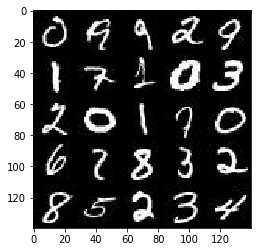

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

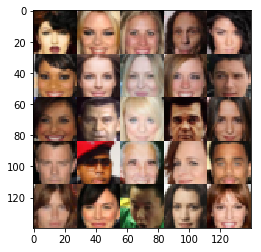

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [26]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_data = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate', shape=())

    return input_data, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [50]:
from functools import reduce
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        keep_prop = 0.8
        alpha = 0.01
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1, keep_prop) 
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prop) 
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prop) 
        # 3x3x256
        
        # Flatten it
        new_shape = reduce(lambda x,y:x*y, relu3.get_shape().as_list()[1:])
        flat = tf.reshape(relu3, (-1, new_shape))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [57]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # XXX: 图片都是28x28的
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        alpha = 0.01
#         keep_prop = 0.8
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
#         x1 = tf.nn.dropout(x1, keep_prop) 
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         x2 = tf.nn.dropout(x2, keep_prop) 
        # 14x14x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xdim now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [75]:
tf.reset_default_graph()

In [58]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [59]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [60]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [61]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     tf.reset_default_graph()
    image_shape = data_shape[1:]
    channel = image_shape[2]
    input_real, input_z, lr = model_inputs(image_shape[0], image_shape[1], image_shape[2], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 50
    show_every = 200
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # scale to -1..1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate,})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate,})
                
                # print loss
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
#                     losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 3*3, input_z, channel, data_image_mode)
        # show last one...
        show_generator_output(sess, 4*4, input_z, channel, data_image_mode)
#         saver.save(sess, './checkpoints/generator.ckpt')
#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
    return losses     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 2.6265
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.6938
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 1.4978... Generator Loss: 1.9678


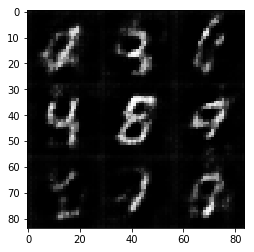

Epoch 1/2... Discriminator Loss: 1.4767... Generator Loss: 0.9520
Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 0.9298
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 1.1878


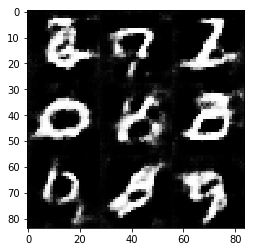

Epoch 1/2... Discriminator Loss: 1.2590... Generator Loss: 1.2371
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 1.2712
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 1.7641
Epoch 1/2... Discriminator Loss: 1.1557... Generator Loss: 1.7305


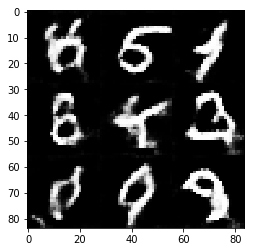

Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 1.1083
Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 1.5175
Epoch 1/2... Discriminator Loss: 1.0400... Generator Loss: 0.9829
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.9863


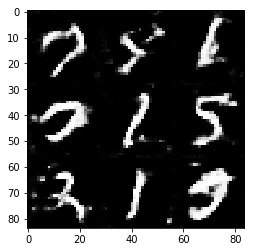

Epoch 1/2... Discriminator Loss: 1.4061... Generator Loss: 0.9347
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 1.2479


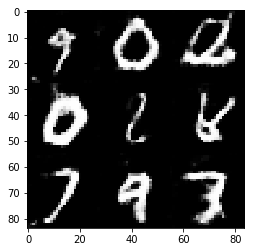

Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 0.9371
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.8356
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 1.0615
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 0.9652


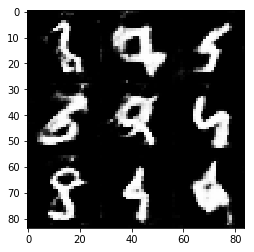

Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.6902
Epoch 1/2... Discriminator Loss: 0.8878... Generator Loss: 1.6090
Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 1.2463
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 0.9608


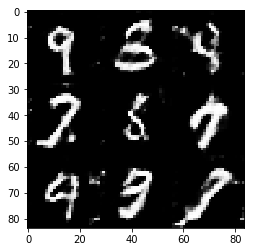

Epoch 1/2... Discriminator Loss: 1.1560... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.6752
Epoch 1/2... Discriminator Loss: 1.4850... Generator Loss: 0.6869
Epoch 1/2... Discriminator Loss: 1.0415... Generator Loss: 1.0262


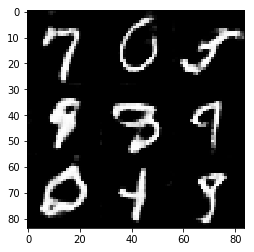

Epoch 1/2... Discriminator Loss: 1.0599... Generator Loss: 1.3431
Epoch 1/2... Discriminator Loss: 1.0366... Generator Loss: 1.4348
Epoch 1/2... Discriminator Loss: 0.9951... Generator Loss: 0.9585
Epoch 1/2... Discriminator Loss: 1.6128... Generator Loss: 0.3635


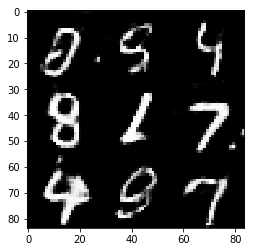

Epoch 1/2... Discriminator Loss: 1.2298... Generator Loss: 0.8849
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 1.9419
Epoch 2/2... Discriminator Loss: 1.8067... Generator Loss: 0.4184
Epoch 2/2... Discriminator Loss: 0.8464... Generator Loss: 2.0671


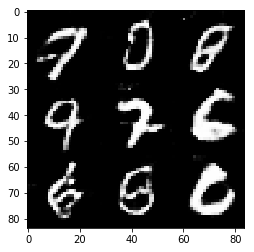

Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 2.0524
Epoch 2/2... Discriminator Loss: 0.9409... Generator Loss: 1.2999
Epoch 2/2... Discriminator Loss: 2.0436... Generator Loss: 0.2656
Epoch 2/2... Discriminator Loss: 2.0919... Generator Loss: 0.4237


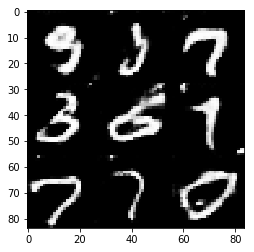

Epoch 2/2... Discriminator Loss: 1.5098... Generator Loss: 0.7494
Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 1.1251
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.7940
Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 1.3354


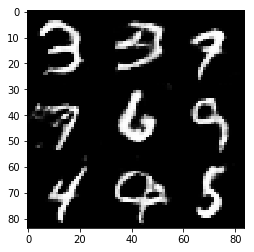

Epoch 2/2... Discriminator Loss: 1.0719... Generator Loss: 0.8755
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 1.1887
Epoch 2/2... Discriminator Loss: 1.0464... Generator Loss: 1.6173
Epoch 2/2... Discriminator Loss: 2.2880... Generator Loss: 0.3652


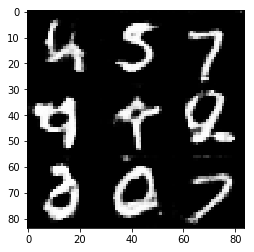

Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 1.3138
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 1.9308
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 1.0955
Epoch 2/2... Discriminator Loss: 1.7386... Generator Loss: 3.0178


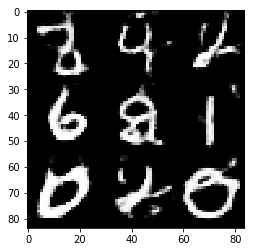

Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 1.0312
Epoch 2/2... Discriminator Loss: 1.3515... Generator Loss: 0.7065
Epoch 2/2... Discriminator Loss: 0.6630... Generator Loss: 2.4143
Epoch 2/2... Discriminator Loss: 1.2321... Generator Loss: 1.1257


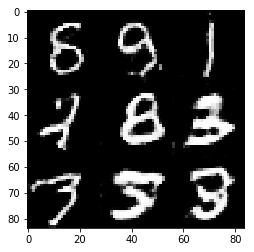

Epoch 2/2... Discriminator Loss: 1.2897... Generator Loss: 1.0583
Epoch 2/2... Discriminator Loss: 2.2337... Generator Loss: 0.2783
Epoch 2/2... Discriminator Loss: 1.3175... Generator Loss: 1.0863
Epoch 2/2... Discriminator Loss: 0.8059... Generator Loss: 1.3486


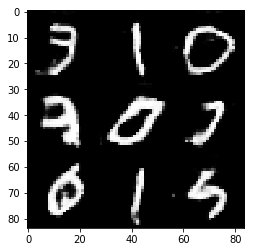

Epoch 2/2... Discriminator Loss: 1.4949... Generator Loss: 0.8087
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 1.0399
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 1.0694


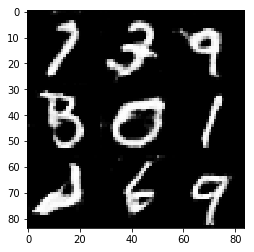

Epoch 2/2... Discriminator Loss: 2.0515... Generator Loss: 0.4314
Epoch 2/2... Discriminator Loss: 0.8902... Generator Loss: 1.3255
Epoch 2/2... Discriminator Loss: 1.5727... Generator Loss: 0.5358
Epoch 2/2... Discriminator Loss: 1.6439... Generator Loss: 0.6291


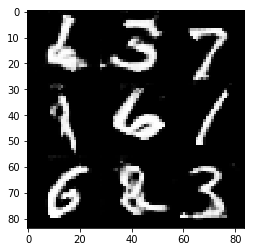

Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 1.1363... Generator Loss: 0.9692
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 1.6606


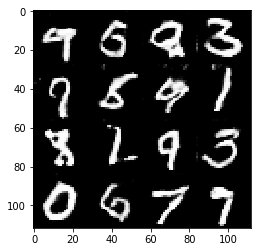

In [62]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 1.7188
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.8352


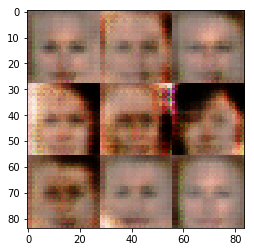

Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 4.7965
Epoch 1/1... Discriminator Loss: 2.0982... Generator Loss: 0.2480
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.3860


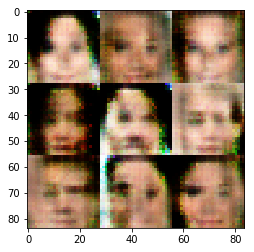

Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 2.4979
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 1.0279


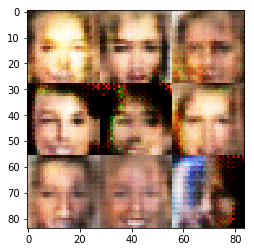

Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.6014
Epoch 1/1... Discriminator Loss: 0.5689... Generator Loss: 1.7516
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.9789


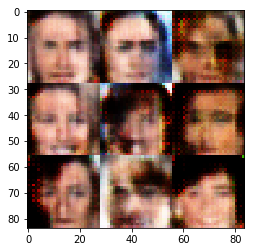

Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 1.7395
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.7668
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.4558


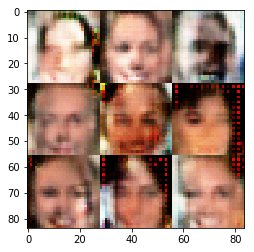

Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.4922
Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 1.3167


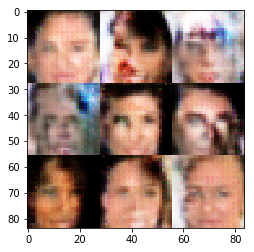

Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.0987


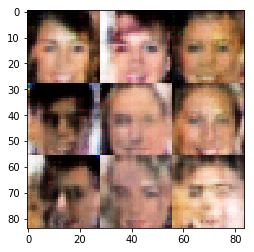

Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 1.5471
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.9014


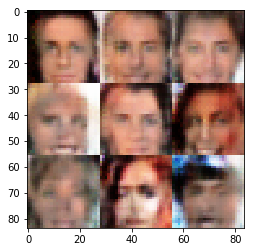

Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.7702... Generator Loss: 0.3787
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.8454


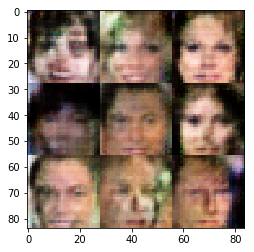

Epoch 1/1... Discriminator Loss: 1.8596... Generator Loss: 0.4004
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 1.4838
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.9488


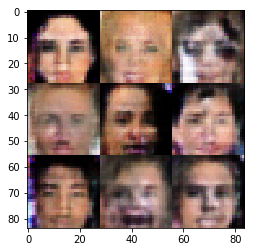

Epoch 1/1... Discriminator Loss: 1.6775... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.6712


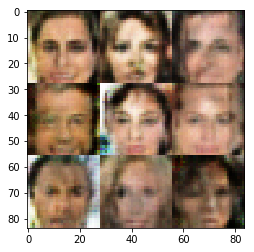

Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 1.7860
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.9333


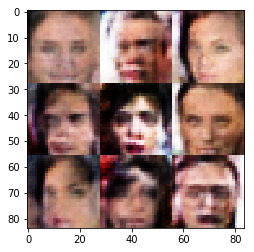

Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7328


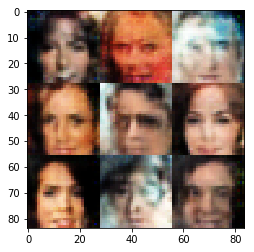

Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 1.1392
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.6404


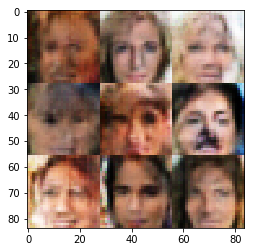

Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.7322


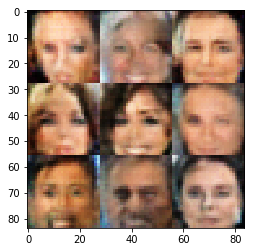

Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.8732


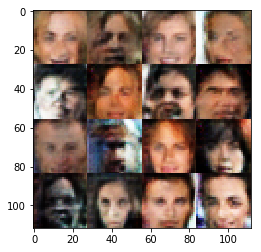

In [63]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.